In [218]:
import librosa

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import pickle

import pandas as pd

import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import torch.onnx

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import LabelEncoder

import os

# import onnx

import scipy.io.wavfile as wav

from numpy.fft import fft

import math

import audiomentations as AA

# Préparation des données d'entraînement et de test

###### Calculs de features

In [219]:
#calcul des magnitudes d'un audio
def magnitude(audio,window):
    samples = len(audio)
    power = 0

    while(2**power <= samples):
        power += 1

    power -= 1
    samples = 2**power

    window = window/sum(window)
    
    weightedAudio = np.asarray(audio * window)
    for i in range(weightedAudio.size):
        weightedAudio[i] = weightedAudio[i]
    hN = int((samples/2))                                            # size of positive spectrum, it includes sample 0
    hM1 = int(math.floor((window.size+1)/2))                     # half analysis window size by rounding
    hM2 = int(math.floor(window.size/2))                         # half analysis window size by floor
    fftbuffer = np.zeros(samples)                                 # initialize buffer for FFT
    fftbuffer[:hM1] = weightedAudio[hM2:]                              # zero-phase window in fftbuffer
    fftbuffer[-hM2:] = weightedAudio[:hM2]

    fftAudio = fft(fftbuffer)

    absX = abs(fftAudio[:hN]) # compute ansolute value of positive side
    absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
    mX = 20 * np.log10(absX)

    return mX[:len(mX)]

In [220]:
#calcul des Mel-scale filter bank coefficients d'un audio
def mel(magnitudes, nb_filters, window_size):
    
    pow_frames = ((1.0 / window_size) * ((np.asarray(magnitudes)) ** 2))  # Power Spectrum des magnitudes

    #Calcul des bins
    sampleRate = 8000
    nqyst = int(sampleRate/2)
    
    high_freq_mel = (2595 * np.log10(1 + nqyst / 700))
    mel_points = [] #taille nfilt+2
    distance = high_freq_mel/(nb_filters+1)
    for i in range(nb_filters+2):
        mel_points.append(distance*i)
    mel_points = np.asarray(mel_points)

    #Calcul de l'échelle correspondante en hertz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    
    #Création des bins
    bins = np.floor((window_size + 1) * hz_points / sampleRate)
    
    fbank = np.zeros((nb_filters, int(np.floor(window_size / 2))))
    
    for m in range(1, nb_filters + 1):
        f_m_minus = int(bins[m - 1])   # left
        f_m = int(bins[m])             # center
        f_m_plus = int(bins[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    return filter_banks

###### Fonctions de récupération de features

In [221]:
#extraction de features Mel-scale filter bank coefficients sur des parties d'audios avec fenêtre glissante et en concatenant les Mel bands de l'audio obtenues
def concatenation_mel_frames_extractor(audios, nb_filters, frame_length = 2048, window_size = 1024, hop_length = 256) :
    sample_length = len(audios[0]) #longueur totale d'un audio
    nb_concat = int(sample_length/frame_length) #nombe d'extraits audio indépendants à traiter (frame_length multiple de sample_length idéalement)
    nb_frames = int((frame_length-window_size)/hop_length)+1 #nombre de frames de nb_filters par extrait audio
    window = np.hamming(window_size)
    coefs = []
    for audio in audios :
        coefs_local = []
        for i in range(nb_concat):
            ffts_local = []
            signal = audio[i*frame_length:i*frame_length+(frame_length)]
            for j in range (nb_frames):
                signal_local = signal[j*hop_length:j*hop_length+window_size]
                ffts_local.append(magnitude(signal_local, window))
            coefs_mel = mel(ffts_local, nb_filters=nb_filters, window_size = window_size)
            for coef in coefs_mel:
                coefs_local.append(coef)
        coefs.append(np.asarray(coefs_local))
    return coefs

##### Ajout de bruits de fond avec audiomentation

In [222]:
def audio_augmentation (audio, sr = 8000, proba = 0.5):
    transform = AA.AddBackgroundNoise(
        sounds_path="./datasetTrainTestToAugment/rp8kHz/backgroundNoise",
        min_snr_db=-44.7,
        max_snr_db=-40.7,
        p=proba
        )

    augmented_sound = transform(audio, sample_rate=sr)

    return augmented_sound

##### Découpage des audios dans une durée choisie, augmentation (optionnelle) avec bruits de fond et normalisation

In [223]:
def cut_raw_audio (audio, nbr_values, probability = 0):
    audios = []
    for n in range(int(len(audio)/nbr_values)-1):
        sample = audio[int(n*nbr_values):int((n+1)*nbr_values)]
        
        #augmentation optionnelle de l'audio
        if(probability != 0):
            sample = audio_augmentation(np.asarray(sample).astype(np.int16), proba = probability)
        
        if(not np.isnan(sample[0])): #parfois addBackgroundNoise d'audiomentation renvoie des arrays de NaN (à régler car perte de sons)
            #min-max normalization (x-xmin/xmax-xmin*(1--1)-1)
            minimum = min(sample)
            sample = ((np.asarray(sample)-minimum)/(max(sample)-minimum))*2-1        
        
            audios.append(sample.tolist())

            #standardization
            #mean = sum(sample)/len(sample)
            #for i in range(len(sample)):
            #    sample[i] = (sample[i]-mean)**2
            #var = sum(sample)/len(sample)
            #for i in range(len(sample)):
            #    sample[i] = (sample[i]-mean)/var

            #audios.append(sample)

    return audios

In [224]:
def get_signal (path):
    signal = []
    if("wav" in path):
        fr, signal = wav.read(path)
        signal = signal.tolist()
    else :
        f = open(path,"r")
        lines = f.readlines()                               
        for i in range (0,len(lines)) :
            s = lines[i].replace("\n","").replace("\r","")
            signal.append(int(s))
    
    return signal

#### Récupération des features des audios des jeux de données

In [470]:
siren_path = "datasetTrainTestToAugment/rp8kHz/sirene_8kHz_Train.rw"
other_path = "datasetTrainTestToAugment/rp8kHz/autre_8kHz_Train.rw"

extracted_features = []
audio_normalized = []

classSiren = "siren"
classOther = "other"

countSiren = 0
countOther = 0

# longueur des extraits audio
nbr_values = 2048 #à 8 kHz = ~ 1/4s

augmentation_proba = 0.5

signalTEMP = get_signal(siren_path) # récupère les audios du jeu de données sirène
audioTEMP = cut_raw_audio(signalTEMP, nbr_values, augmentation_proba) # coupe les audios dans la longueur nbr_values
                                                                            # et les augmente de augmentation_proba %
nbr_of_audios = len(audioTEMP)
for i in range(nbr_of_audios):
    extracted_features.append([0, classSiren, siren_path+"_"+str(i)+"/"+str(nbr_of_audios)]) #attribue un label à l'audio, lui associe un titre
    audio_normalized.append(audioTEMP[i]) #stock avant le traitement de l'audio
    countSiren +=1

signalTEMP = get_signal(other_path)
audioTEMP = cut_raw_audio(signalTEMP, nbr_values, augmentation_proba)
nbr_of_audios = len(audioTEMP)
for i in range(nbr_of_audios):
    extracted_features.append([0, classOther, other_path+"_"+str(i)+"/"+str(nbr_of_audios)])
    audio_normalized.append(audioTEMP[i])
    countOther +=1
    
print("Nbr d'extraits sirènes : "+str(countSiren) + "; pourcentage : "+str(countSiren/len(audio_normalized))+"%")
print("Nbr d'extraits autres :"+str(countOther) + "; pourcentage : "+str(countOther/len(audio_normalized))+"%")

#calculs des features des extraits audio

# features_audio_normalized = features_extractor_from_audios(audio_normalized)
# features_audio_normalized = fft_extractor(audio_normalized)
features_audio_normalized = concatenation_mel_frames_extractor(audio_normalized, frame_length = 2048, nb_filters = 32, window_size = 512, hop_length = 384)

for i in range(len(features_audio_normalized)):
    extracted_features[i][0] = features_audio_normalized[i].tolist()

C:\Users\User\AppData\Local\Temp\ipykernel_8296\3813085728.py:13: RuntimeWarning: overflow encountered in short_scalars
  sample = ((np.asarray(sample)-minimum)/(max(sample)-minimum))*2-1
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\audiomentations\core\utils.py:81: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.mean(np.square(samples)))


Nbr d'extraits sirènes : 444; pourcentage : 0.5174825174825175%
Nbr d'extraits autres :414; pourcentage : 0.4825174825174825%


In [15]:
len(extracted_features[0][0])

5

##### Enregistrement des features du jeu de train

In [471]:
#sauvegarde des features sous format .pkl

f = open('datasetFeatures/concat2048from2048_5frames_32coefs_Train_p05.pkl','wb') #jeu de train avec 50% d'augmentation

pickle.dump(extracted_features, f)
f.close()

#### Extraction des features du jeu de test fixe

In [476]:
#extraction des features d'un jeu de test
# jeux de test sans augmentation et avec augmentation à créer avec la partie :
# "Augmentation d'un jeu de test et enregistrement (pour avoir des augmentations non variables)" à la fin du notebook

siren_path_test = "datasetTrainTestToAugment/rp8kHz/sirene_8kHz_Test.rw"
other_path_test = "datasetTrainTestToAugment/rp8kHz/autre_8kHz_Test.rw"

# siren_path_test = "datasetTrainTestToAugment/rp8kHz/sirene_8kHz_Test_Augmented_p1.wav"
# other_path_test = "datasetTrainTestToAugment/rp8kHz/autre_8kHz_Test_Augmented_p1.wav"

# siren_path_test = "datasetTrainTestToAugment/rp8kHz/sirene_8kHz_Test_Augmented_p05.wav"
# other_path_test = "datasetTrainTestToAugment/rp8kHz/autre_8kHz_Test_Augmented_p05.wav"

classSiren = "siren"
classOther = "other"

countSiren = 0
countOther = 0

extracted_features_test = []
audio_normalized_test = []

signalTEMP = get_signal(siren_path_test)

audioTEMP = cut_raw_audio(signalTEMP, nbr_values)
nbr_of_audios = len(audioTEMP)
for i in range(nbr_of_audios):
    extracted_features_test.append([0, classSiren, siren_path_test+"_"+str(i)+"/"+str(nbr_of_audios)])
    audio_normalized_test.append(audioTEMP[i])
    countSiren +=1
    
signalTEMP = get_signal(other_path_test)

audioTEMP = cut_raw_audio(signalTEMP, nbr_values)
nbr_of_audios = len(audioTEMP)
for i in range(nbr_of_audios):
    extracted_features_test.append([0, classOther, other_path_test+"_"+str(i)+"/"+str(nbr_of_audios)])
    audio_normalized_test.append(audioTEMP[i])
    countOther +=1
    
print("Nbr d'extraits sirènes : "+str(countSiren) + "; pourcentage : "+str(countSiren/len(audio_normalized_test))+"%")
print("Nbr d'extraits autres :"+str(countOther) + "; pourcentage : "+str(countOther/len(audio_normalized_test))+"%")
    
# features_audio_normalized_test = mel_frames_extractor(audio_normalized_test, nb_filters = 32, window_size = 2048, hop_length = 1024)
features_audio_normalized_test = concatenation_mel_frames_extractor(audio_normalized_test, frame_length = 2048, nb_filters = 32, window_size = 512, hop_length = 384)


for i in range(len(features_audio_normalized_test)):
    extracted_features_test[i][0] = features_audio_normalized_test[i].tolist()

Nbr d'extraits sirènes : 50; pourcentage : 0.5319148936170213%
Nbr d'extraits autres :44; pourcentage : 0.46808510638297873%


##### Enregistrement des features du jeu de test

In [477]:
f = open('datasetFeatures/concat2048from2048_5frames_32coefs_Test_p0','wb') #jeu de test sans augmentation
# f = open('datasetFeatures/concat2048from2048_5frames_32coefs_Test_p05','wb') #jeu de test avec 50% d'augmentation
# f = open('datasetFeatures/concat2048from2048_5frames_32coefs_Test_p1','wb') #jeu de test avec 100% d'augmentation

pickle.dump(extracted_features_test, f)
f.close()

# Apprentissage MLP et CNN Tensorflow

##### Séparation des données enregistrées en test/train  pour modèle Tensorflow

In [689]:
# Chargement du jeu de train

f = open('datasetFeatures/concat2048from2048_5frames_32coefs_Train_p05.pkl','rb')

Data = pickle.load(f)
f.close()
#transformation des données sous forme de DataFrame
df = pd.DataFrame(Data,columns=['feature','class','file'])
df.head()
print(df.shape)

(3262, 3)


In [692]:
# Chargement du jeu de test

f = open('datasetFeatures/concat2048from2048_5frames_32coefs_Test_p05.pkl','rb')

Data_test = pickle.load(f)
f.close()
#transformation des données sous forme de DataFrame
df_test = pd.DataFrame(Data_test,columns=['feature','class','file'])
df_test.head()
print(df_test.shape)

(382, 3)


In [693]:
#mélange du dataframe suivant un int seed pour avoir toujours le même mélange
df_sample = df.sample(frac=1, random_state=0)

#création du dataset tensorflow avec les labels encodés
labels = df_sample['class']
labels = LabelEncoder().fit_transform(labels)
numeric_features = df_sample['feature']
for i in range(numeric_features.shape[0]):
    numeric_features[i] = np.asarray(numeric_features[i]).astype('float32')
    
numeric_features = np.array([np.array(val) for val in numeric_features])

numeric_dataset = tf.data.Dataset.from_tensor_slices((numeric_features, labels))

In [694]:
df_sample = df_test.sample(frac=1, random_state=0)

labels = df_sample['class']
labels = LabelEncoder().fit_transform(labels)
numeric_features = df_sample['feature']
for i in range(numeric_features.shape[0]):
    numeric_features[i] = np.asarray(numeric_features[i]).astype('float32')
    
numeric_features = np.array([np.array(val) for val in numeric_features])

numeric_dataset_test = tf.data.Dataset.from_tensor_slices((numeric_features, labels))

In [695]:
test_dataset = numeric_dataset_test#.skip(1)
train_dataset = numeric_dataset
print(len(test_dataset))

382


In [696]:
#création de batches sur les jeux de données
batch_size = 15

test_batches = test_dataset.batch(batch_size)
train_batches = train_dataset.batch(batch_size)

In [697]:
print(np.asarray(df['feature'][0]).shape)

(5, 32)


### CNN Tensorflow

In [698]:
optimizer = tf.keras.optimizers.Adam(
    decay=0,
    learning_rate=0.001
)

normalizer = tf.keras.layers.BatchNormalization()

def get_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(5, 32, 1)),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
#         normalizer,
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer=optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

### MLP Tensorflow

In [77]:
normalizer = tf.keras.layers.BatchNormalization()

optimizer = tf.keras.optimizers.Adam(
    decay=0.1,
    learning_rate=0.01
)


def get_mlp_model():
    model = tf.keras.Sequential([
#         normalizer,
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation ='sigmoid')
      ])

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [699]:
model = get_cnn_model()

In [700]:
#entraînement du modèle sur le jeu de données train
model.fit(train_batches, shuffle = 0, epochs=30)

Epoch 1/30
218/218 [==============================] - 1s 2ms/step - loss: 0.6623 - accuracy: 0.6070
Epoch 2/30
218/218 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.7364
Epoch 3/30
218/218 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.7906
Epoch 4/30
218/218 [==============================] - 0s 2ms/step - loss: 0.3983 - accuracy: 0.8326
Epoch 5/30
218/218 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.8495
Epoch 6/30
218/218 [==============================] - 0s 2ms/step - loss: 0.3257 - accuracy: 0.8642
Epoch 7/30
218/218 [==============================] - 0s 2ms/step - loss: 0.2907 - accuracy: 0.8811
Epoch 8/30
218/218 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.8912
Epoch 9/30
218/218 [==============================] - 0s 1ms/step - loss: 0.2544 - accuracy: 0.8994
Epoch 10/30
218/218 [==============================] - 0s 2ms/step - loss: 0.2377 - accuracy: 0.9059

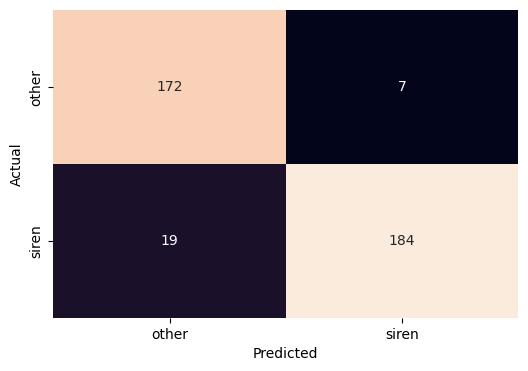

0.9319371727748691 %


In [701]:
#évaluation de la précision sur le jeu de données test avec le score d'accuracy et une matrice de confusion
y = model.predict(test_batches)

y_pred = []
for _ in y:
    pred = 0
    if(_[0]>=0.5):
        pred = 1
    y_pred.append(pred)

y_true = []
for inp, lab in test_dataset :
    y_true.append(lab.numpy())
    
conf_mat = confusion_matrix(y_true,
                            y_pred)

tn, fp, fn, tp = conf_mat.ravel()

labelencoder = LabelEncoder()
y = torch.tensor(labelencoder.fit_transform(['other','siren']))

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(str((tp+tn)/len(test_dataset))+" %")

In [702]:
model.summary()

Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_282 (Conv2D)         (None, 3, 30, 8)          80        
                                                                 
 max_pooling2d_282 (MaxPooli  (None, 2, 15, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_283 (Conv2D)         (None, 2, 15, 16)         1168      
                                                                 
 max_pooling2d_283 (MaxPooli  (None, 1, 8, 16)         0         
 ng2D)                                                           
                                                                 
 flatten_141 (Flatten)       (None, 128)               0         
                                                                 
 dense_282 (Dense)           (None, 10)             

###### Enregistrement du modèle entraîné en TensorflowLite

In [598]:
# conversion du modèle au format TensorFlowLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# sauvegarde du modèle
open("finalcalculation_concat4096from8192_5frames32coefs_normalization_8kHz_augmented_p05_prct.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("finalcalculation_concat4096from8192_5frames32coefs_normalization_8kHz_augmented_p05_prct.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpql5vaaai\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpql5vaaai\assets


Model is 28700 bytes


In [ ]:
## Pas utilisé car utilisation de EdgeImpulse avec le modèle créé ci-dessus pour importer le modèle sur Arduino
## Header c++/Arduino à créer sur Colab via ce lien https://colab.research.google.com/drive/1HT0kYt1cFgC2lfZwO6sJVotYmjCrqhII#scrollTo=e6de24c5 en copie/collant le modèle TFLite dans Colab

##### Test du modèle tflite avec des coefs mel d'arduino (pour comparer les résultats des 2 calculs)

In [169]:
#0.11 sur Arduino -> 0.113 sur python
coefArduino1 = [[25.91,28.80,27.74,25.49,23.33,23.88,21.03,22.73,23.81,19.19,19.63,20.12,18.06,19.03,25.85,25.26,21.75,21.46,23.36,20.35,18.96,23.42,23.22,22.92,25.08,21.74,28.91,30.27,29.55,26.46,-300.00,-300.00],[18.89,19.61,15.95,14.22,13.21,15.88,14.59,17.08,17.05,14.99,13.24,12.60,14.43,16.40,23.55,18.43,14.97,20.63,20.54,17.87,15.57,18.65,18.82,19.98,24.45,21.07,27.76,24.87,27.46,25.39,-300.00,-300.00],[17.37,19.74,17.28,15.42,15.06,13.82,11.93,14.73,17.62,15.59,10.76,13.68,16.35,17.19,22.94,18.04,13.08,18.24,20.88,17.97,19.86,19.46,19.19,21.46,25.22,22.40,23.55,23.03,26.36,24.60,-300.00,-300.00],[19.25,20.65,17.75,16.70,17.38,10.49,11.64,15.60,17.77,12.27,11.85,13.34,13.84,16.16,20.15,19.08,15.92,17.87,17.11,15.75,16.54,19.84,14.63,21.07,24.07,21.38,27.30,25.38,27.10,25.69,-300.00,-300.00],[18.53,20.59,15.31,12.81,15.76,14.20,14.76,12.18,16.30,11.82,9.96,5.66,10.47,16.91,22.31,18.72,13.53,14.41,18.05,10.87,15.79,19.71,17.35,21.24,21.02,19.97,24.92,23.40,24.91,20.98,-300.00,-300.00],[16.14,18.59,17.00,16.00,17.45,12.17,11.10,12.48,16.56,13.02,11.93,14.14,10.73,17.95,23.01,17.54,15.86,15.41,18.63,18.37,17.48,19.77,17.91,22.29,23.60,22.61,27.43,24.06,25.42,26.08,-300.00,-300.00],[16.08,19.26,17.22,15.29,16.93,14.90,11.82,12.35,17.27,16.89,12.51,13.17,13.62,14.26,17.67,15.03,14.22,17.50,15.90,11.65,14.84,21.01,20.51,17.11,21.81,20.59,22.43,21.83,25.41,24.35,-300.00,-300.00],[16.32,20.14,15.88,15.65,15.97,14.20,14.60,12.76,15.83,11.56,9.43,8.56,12.10,15.49,22.26,16.69,15.04,17.46,18.88,13.94,17.27,21.78,19.54,16.94,23.42,18.37,23.39,22.91,24.90,22.98,-300.00,-300.00],[17.22,19.06,16.27,18.44,17.51,15.97,14.50,10.60,17.65,15.68,6.87,11.70,11.48,15.87,22.17,16.50,14.18,17.74,18.22,16.99,18.35,22.10,21.24,20.89,25.00,20.92,24.22,23.38,24.39,22.32,-300.00,-300.00],[18.48,20.07,16.87,17.74,15.29,13.20,13.97,10.79,14.64,16.26,11.51,11.62,10.68,12.42,18.61,15.35,10.10,12.78,15.30,14.17,16.60,21.67,23.56,20.11,21.08,19.70,24.60,23.43,24.11,23.07,-300.00,-300.00],[16.45,19.82,16.53,12.59,14.17,11.95,15.12,17.20,18.73,14.69,12.01,14.44,13.60,16.23,22.21,17.87,14.37,16.38,20.34,15.36,17.32,24.40,23.63,19.53,21.98,20.63,23.80,22.30,24.99,24.56,-300.00,-300.00],[17.19,19.42,16.12,14.45,12.75,11.26,11.61,13.26,15.88,16.15,14.42,12.78,7.59,14.30,22.26,16.82,14.03,13.78,18.14,15.04,15.81,22.22,20.98,19.01,21.25,17.92,22.85,20.21,22.17,22.55,-300.00,-300.00],[13.85,16.98,15.45,15.46,15.14,11.19,10.04,12.09,16.27,12.00,6.60,15.42,17.02,17.96,21.65,15.10,13.97,17.85,17.43,15.09,16.38,19.22,19.13,14.84,22.67,17.41,23.16,21.52,24.26,22.52,-300.00,-300.00],[14.47,17.97,10.95,12.69,14.78,15.04,15.56,14.60,16.54,13.24,11.24,15.56,14.51,15.23,21.91,17.79,13.97,15.97,21.76,15.84,15.55,23.54,21.87,15.60,24.77,21.02,25.28,24.76,25.16,24.42,-300.00,-300.00],[14.00,17.12,15.23,15.27,11.98,10.73,14.77,14.28,17.10,14.11,7.91,14.30,11.79,17.44,24.11,17.71,18.08,18.30,18.62,14.43,19.47,23.52,20.02,18.40,26.32,20.11,24.98,25.23,27.03,25.18,-300.00,-300.00],[15.51,18.14,11.07,11.92,11.37,13.14,11.50,16.50,17.40,7.77,7.67,15.18,16.23,18.15,20.59,16.22,11.83,18.84,22.02,17.52,21.24,24.76,22.64,22.34,24.48,22.71,27.03,25.36,27.16,25.50,-300.00,-300.00],[12.54,15.54,12.80,10.62,14.64,11.05,14.67,13.89,18.20,17.16,5.65,11.87,13.56,17.70,24.26,20.75,16.49,14.74,17.32,13.52,14.42,20.71,17.53,21.28,23.55,20.37,26.22,25.76,24.48,21.51,-300.00,-300.00],[12.34,16.51,10.69,13.54,11.69,8.44,11.28,14.07,15.11,12.18,11.72,9.20,13.01,17.33,24.73,22.70,18.42,19.76,22.68,21.68,20.02,19.61,22.33,23.05,27.66,25.99,28.70,30.56,25.51,22.08,-300.00,-300.00]]
print(len(coefArduino1))

In [171]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="concat4096from8192_18frames32coefs_8kHz_normal.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
data = np.asarray(coefArduino1, dtype=np.float32).reshape(input_data.shape)
interpreter.set_tensor(input_details[0]['index'], data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.1249]]


### Augmentation d'un jeu de test et enregistrement (pour avoir des augmentations non variables)

In [519]:
def cut_and_augment_test_audio (audio, probability):
    audios = []
    
    for n in range(int(len(audio)/nbr_values)):
        sample = audio[int(n*nbr_values):int((n)*nbr_values+nbr_values)]
        sample = audio_augmentation(np.asarray(sample).astype(np.int16), proba = probability)
        if(not np.isnan(sample[0])):
            audios.append(sample)
            
    return np.asarray(audios).flatten()

In [10]:
#enregistrements de features de jeu de test avec plusieurs degrés d'augmentation (0%, 50% et 100%)
#opération à ne faire qu'une fois par jeu de test

siren_path_test = "datasetTrainTestToAugment/rp8kHz/sirene_8kHz_Test.rw"
other_path_test = "datasetTrainTestToAugment/rp8kHz/autre_8kHz_Test.rw"

signalTEMP = get_signal(siren_path_test)

#cut_and_augment_test_audio : méthode à instancier plus bas

#augmentations et sauvegarde du jeu de test augmenté
wav.write("datasetTrainTestToAugment/rp8kHz/sirene_8kHz_Test_Augmented_p1.wav", 8000, cut_and_augment_test_audio(signalTEMP,1).astype(np.int16))
wav.write("datasetTrainTestToAugment/rp8kHz/sirene_8kHz_Test_Augmented_p05.wav", 8000, cut_and_augment_test_audio(signalTEMP,0.5).astype(np.int16))

signalTEMP = get_signal(other_path_test)

#augmentations et sauvegarde du jeu de test augmenté
wav.write("datasetTrainTestToAugment/rp8kHz/autre_8kHz_Test_Augmented_p1.wav", 8000, cut_and_augment_test_audio(signalTEMP,1).astype(np.int16))
wav.write("datasetTrainTestToAugment/rp8kHz/autre_8kHz_Test_Augmented_p05.wav", 8000, cut_and_augment_test_audio(signalTEMP,0.5).astype(np.int16))

### Archives d'autres méthodes d'extraction de features

In [21]:
#calcul le spectrogramme d'un audio (deprecated/not used)
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):
    stride_size = 128
    window_size = 256

    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, 256)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [10]:
#extraction de features MFCC des audios
numberOfFeatures = 15

def features_extractor_from_audios(audios):
    mfcc = []
    sample_rate = 8000
    for audio in audios :
        npaudio = np.asarray(audio).astype(float)
        temp = librosa.feature.mfcc(y=npaudio, sr=sample_rate, n_mfcc=numberOfFeatures, hop_length = 128, n_fft = 256)
        mfcc.append(np.mean(temp.T, axis=0))
    return mfcc

In [20]:
#extraction de feature MelSpectrogram des audios
def librosa_mel_frames_extractor(audios, nb_filters, window_size = 256, hop_length = 128):
    mels = []
    for audio in audios :
        S = librosa.feature.melspectrogram(y=np.asarray(audio).astype(float), sr=4100, n_mels = nb_filters, hop_length = hop_length, win_length = window_size)
        mels.append(S)
    return mels

In [ ]:
#extraction de features magnitudes des audios sans fenêtre glissante
def fft_extractor(audios):
    window = np.hamming(len(audios[0]))
    ffts = []
    for audio in audios :
            
        ffts.append(magnitude(audio, window))
            
    return ffts

In [22]:
#extraction de feature spectrogramme des audios
def spec_extractor (audios):
    spectrograms = []
    for audio in audios :
        spectrograms.append(spectrogram(np.asarray(audio), 4100, max_freq=32000))
    return spectrograms